<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_VGG19_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 30 07:12:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   33C    P0    51W / 165W |      0MiB / 24258MiB |     93%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6149815260000651
GPU (s):
0.0349738879999677
GPU speedup over CPU: 17x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(convert_color, original=False, preprocess=False):

  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.vgg16.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.vgg16.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
58900480/58889256 [==============================] - 49s 1us/step
Using the original RGB and preprocessing
Epoch 1/100
360/360 [==============================] - 19s 41ms/step - loss: 1.0486 - accuracy: 0.6501 - val_loss: 0.6166 - val_accuracy: 0.7265
Epoch 2/100
360/360 [==============================] - 18s 51ms/step - loss: 0.6389 - accuracy: 0.7275 - val_loss: 0.5887 - val_accuracy: 0.7329
Epoch 3/100
360/360 [==============================] - 14s 40ms/step - loss: 0.5873 - accuracy: 0.7476 - val_loss: 0.5219 - val_accuracy: 0.7765
Epoch 4/100
360/360 [==============================] - 14s 40ms/step - loss: 0.5642 - accuracy: 0.7545 - val_loss: 0.5181 - val_accuracy: 0.7796
Epoch 5/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5538 - accuracy: 0.7586 - val_loss: 0.5102 - val_accuracy: 0.7767
Epoch 6/100
360/360

360/360 [==============================] - 14s 38ms/step - loss: 0.3989 - accuracy: 0.8343 - val_loss: 0.4217 - val_accuracy: 0.8315
Epoch 55/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4032 - accuracy: 0.8330 - val_loss: 0.4180 - val_accuracy: 0.8334
Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3978 - accuracy: 0.8350 - val_loss: 0.3980 - val_accuracy: 0.8435
Epoch 57/100
360/360 [==============================] - 16s 44ms/step - loss: 0.3982 - accuracy: 0.8344 - val_loss: 0.4487 - val_accuracy: 0.8204
Epoch 58/100
360/360 [==============================] - 14s 39ms/step - loss: 0.3947 - accuracy: 0.8355 - val_loss: 0.4086 - val_accuracy: 0.8395
Epoch 59/100
360/360 [==============================] - 14s 38ms/step - loss: 0.3934 - accuracy: 0.8376 - val_loss: 0.4214 - val_accuracy: 0.8288
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 0.3954 - accuracy: 0.8371 - val_loss: 0.4409 - val_accuracy

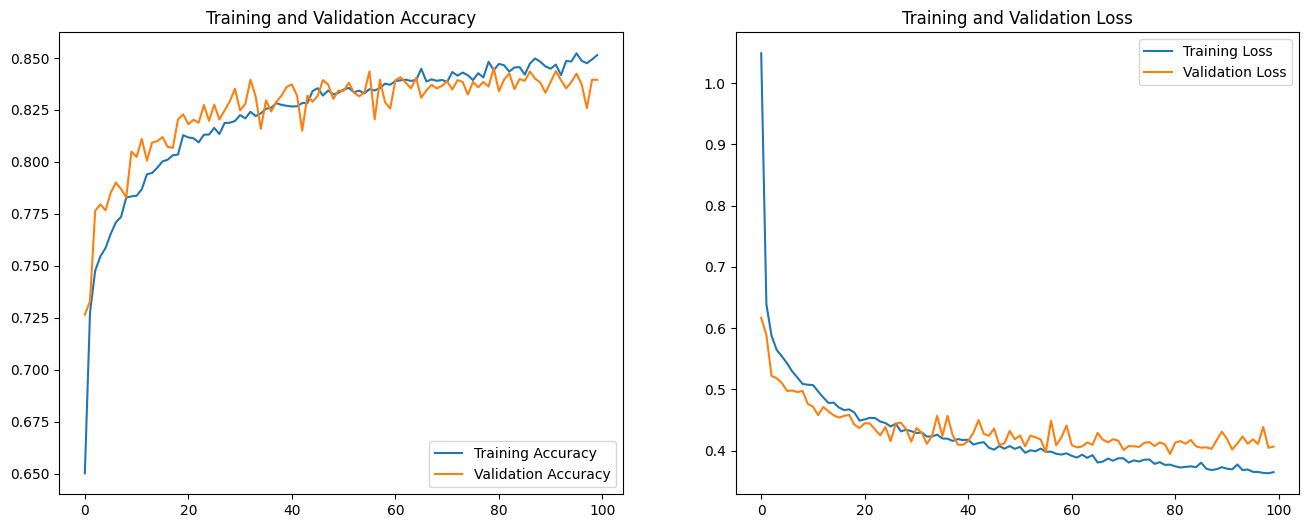

In [5]:
res_rgb = train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 39ms/step - loss: 0.9996 - accuracy: 0.6518 - val_loss: 0.6122 - val_accuracy: 0.7391
Epoch 2/100
360/360 [==============================] - 16s 45ms/step - loss: 0.6623 - accuracy: 0.7208 - val_loss: 0.5728 - val_accuracy: 0.7582
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6162 - accuracy: 0.7388 - val_loss: 0.5423 - val_accuracy: 0.7695
Epoch 4/100
360/360 [==============================] - 14s 40ms/step - loss: 0.5935 - accuracy: 0.7457 - val_loss: 0.5351 - val_accuracy: 0.7770
Epoch 5/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5763 - accuracy: 0.7570 - val_loss: 0.5186 - val_accuracy: 0.7819
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.

Epoch 56/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4452 - accuracy: 0.8177 - val_loss: 0.4471 - val_accuracy: 0.8241
Epoch 57/100
360/360 [==============================] - 14s 39ms/step - loss: 0.4471 - accuracy: 0.8179 - val_loss: 0.4555 - val_accuracy: 0.8159
Epoch 58/100
360/360 [==============================] - 14s 40ms/step - loss: 0.4475 - accuracy: 0.8158 - val_loss: 0.4516 - val_accuracy: 0.8154
Epoch 59/100
360/360 [==============================] - 14s 39ms/step - loss: 0.4404 - accuracy: 0.8195 - val_loss: 0.4480 - val_accuracy: 0.8220
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4409 - accuracy: 0.8173 - val_loss: 0.4485 - val_accuracy: 0.8199
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4403 - accuracy: 0.8179 - val_loss: 0.4538 - val_accuracy: 0.8213
Epoch 62/100
360/360 [==============================] - 14s 40ms/step - loss: 0.4441 - accuracy: 0.8190 - val_loss: 0.4686 -

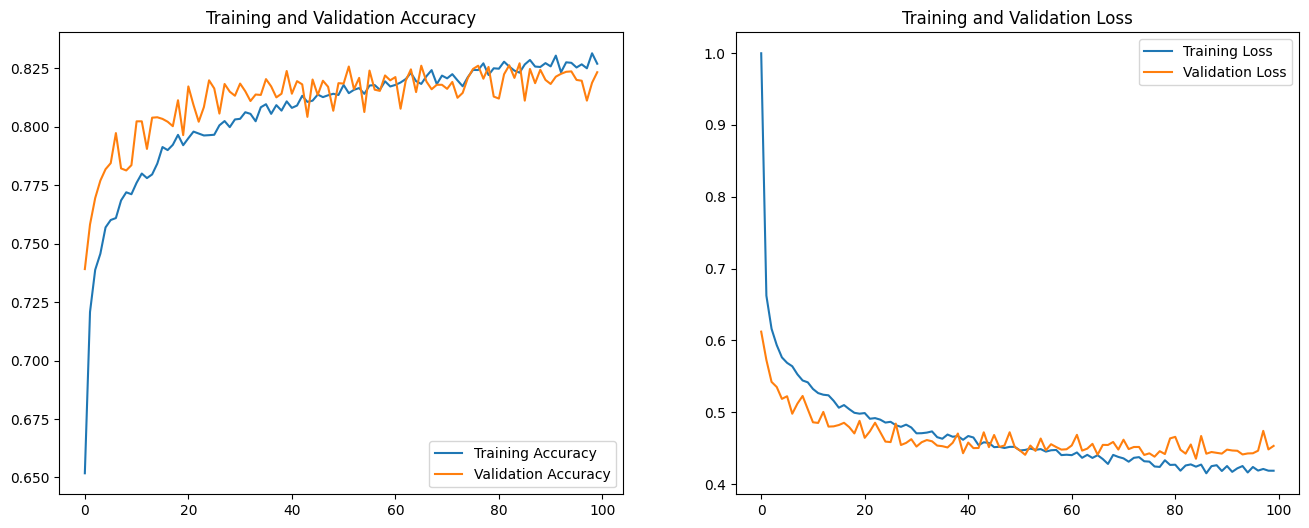

In [6]:
res_lab_pre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 17s 40ms/step - loss: 0.9137 - accuracy: 0.6550 - val_loss: 0.6804 - val_accuracy: 0.7055
Epoch 2/100
360/360 [==============================] - 14s 40ms/step - loss: 0.6907 - accuracy: 0.7076 - val_loss: 0.6265 - val_accuracy: 0.7319
Epoch 3/100
360/360 [==============================] - 15s 41ms/step - loss: 0.6538 - accuracy: 0.7227 - val_loss: 0.5916 - val_accuracy: 0.7530
Epoch 4/100
360/360 [==============================] - 14s 40ms/step - loss: 0.6328 - accuracy: 0.7354 - val_loss: 0.5763 - val_accuracy: 0.7569
Epoch 5/100
360/360 [==============================] - 14s 39ms/step - loss: 0.6097 - accuracy: 0.7452 - val_loss: 0.5591 - val_accuracy: 0.7737
Epoch 6/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5868 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4598 - accuracy: 0.8147 - val_loss: 0.4461 - val_accuracy: 0.8232
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4463 - accuracy: 0.8200 - val_loss: 0.4449 - val_accuracy: 0.8239
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4535 - accuracy: 0.8196 - val_loss: 0.4444 - val_accuracy: 0.8230
Epoch 59/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4505 - accuracy: 0.8199 - val_loss: 0.4347 - val_accuracy: 0.8241
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4514 - accuracy: 0.8211 - val_loss: 0.4538 - val_accuracy: 0.8147
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4513 - accuracy: 0.8209 - val_loss: 0.4461 - val_accuracy: 0.8180
Epoch 62/100
360/360 [==============================] - 14s 39ms/step - loss: 0.4526 - accuracy: 0.8186 - val_loss: 0.4403 -

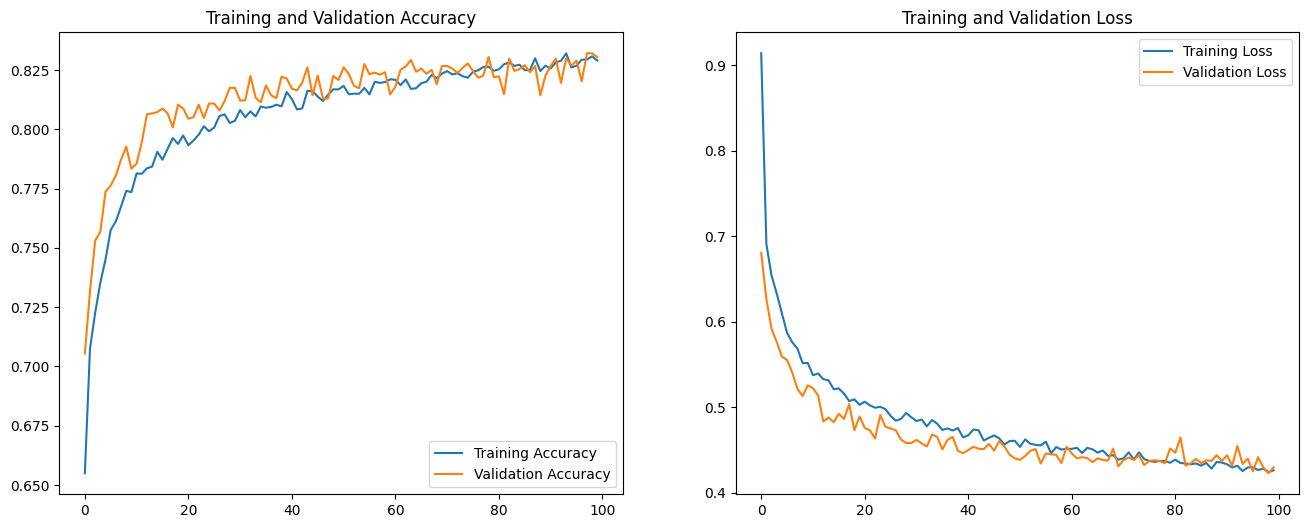

In [7]:
res_lab_nonpre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 39ms/step - loss: 1.6932 - accuracy: 0.2776 - val_loss: 1.4145 - val_accuracy: 0.2860
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4426 - accuracy: 0.2794 - val_loss: 1.4134 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4305 - accuracy: 0.2813 - val_loss: 1.4168 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4289 - accuracy: 0.2862 - val_loss: 1.4189 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4260 - accuracy: 0.2893 - val_loss: 1.4129 - val_accuracy: 0.2890
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4226 - accuracy: 0.2949 - val_loss: 1.4135 - val_accuracy: 0.2860
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4225 - accuracy: 0.2952 - val_loss: 1.4131 - val_accuracy: 0.2860
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4229 - accuracy: 0.2943 - val_loss: 1.4137 - val_accuracy: 0.2860
Epoch 59/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4230 - accuracy: 0.2946 - val_loss: 1.4140 - val_accuracy: 0.2860
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4223 - accuracy: 0.2946 - val_loss: 1.4136 - val_accuracy: 0.2860
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4228 - accuracy: 0.2942 - val_loss: 1.4140 - val_accuracy: 0.2860
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4223 - accuracy: 0.2942 - val_loss: 1.4139 -

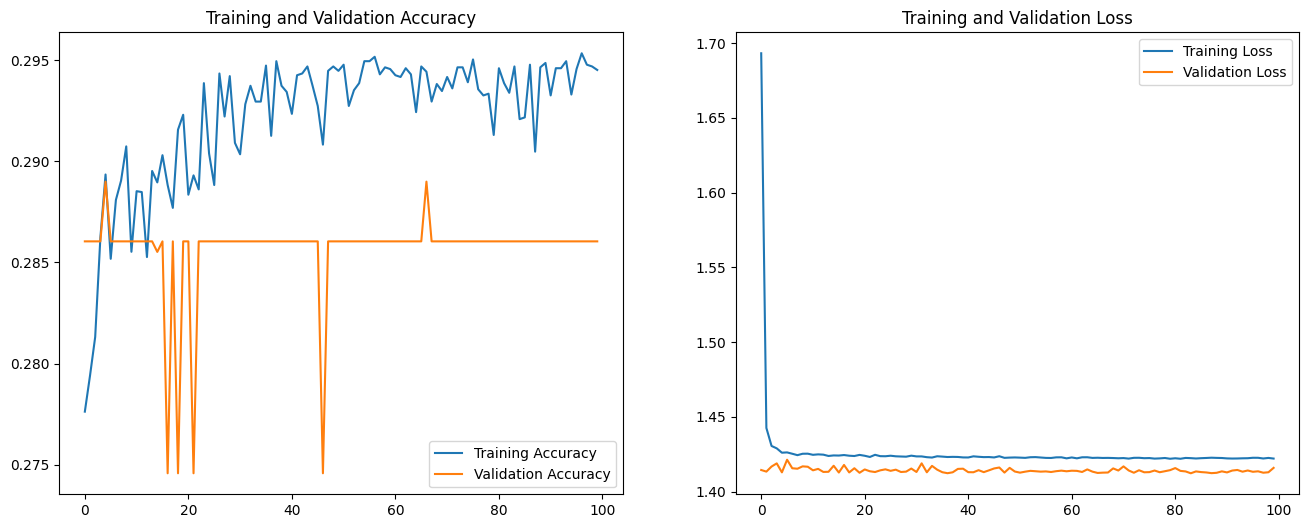

In [8]:
res_xyz_pre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 16s 38ms/step - loss: 1.0385 - accuracy: 0.5340 - val_loss: 0.8314 - val_accuracy: 0.6348
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8815 - accuracy: 0.6181 - val_loss: 0.7810 - val_accuracy: 0.6573
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8507 - accuracy: 0.6321 - val_loss: 0.7577 - val_accuracy: 0.6716
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8309 - accuracy: 0.6419 - val_loss: 0.7851 - val_accuracy: 0.6405
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8163 - accuracy: 0.6488 - val_loss: 0.7558 - val_accuracy: 0.6832
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.7971 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6639 - accuracy: 0.7199 - val_loss: 0.6085 - val_accuracy: 0.7416
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6591 - accuracy: 0.7273 - val_loss: 0.6230 - val_accuracy: 0.7334
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6593 - accuracy: 0.7251 - val_loss: 0.6008 - val_accuracy: 0.7516
Epoch 59/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6608 - accuracy: 0.7240 - val_loss: 0.5869 - val_accuracy: 0.7515
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6600 - accuracy: 0.7262 - val_loss: 0.6123 - val_accuracy: 0.7352
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6579 - accuracy: 0.7278 - val_loss: 0.6015 - val_accuracy: 0.7457
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6541 - accuracy: 0.7250 - val_loss: 0.5928 -

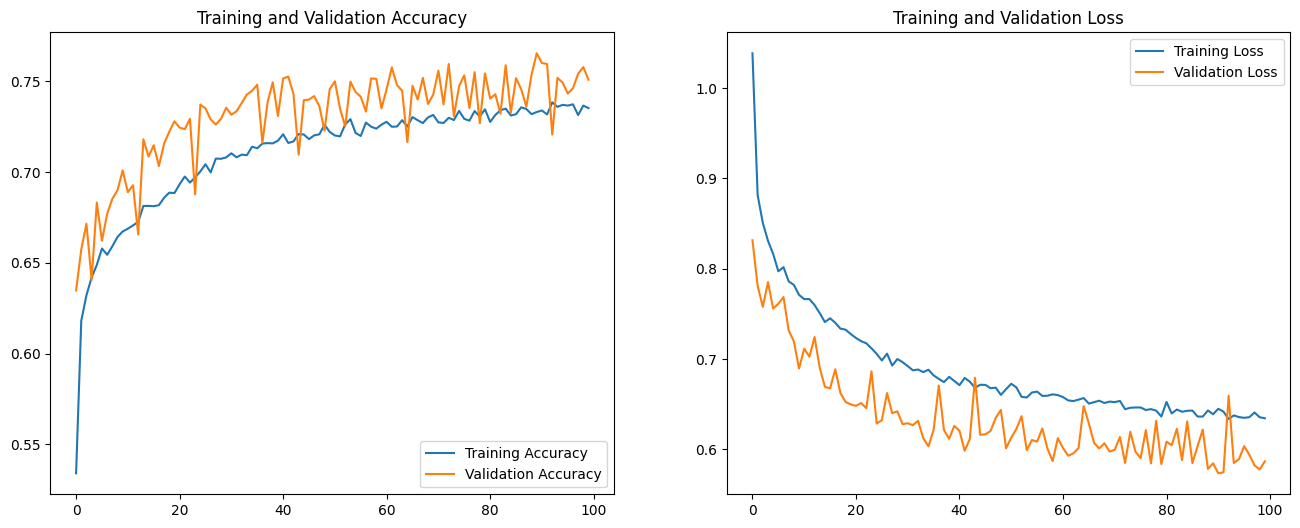

In [9]:
res_xyz_nonpre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 38ms/step - loss: 1.6810 - accuracy: 0.2790 - val_loss: 1.4062 - val_accuracy: 0.2973
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4342 - accuracy: 0.2928 - val_loss: 1.4073 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4173 - accuracy: 0.3098 - val_loss: 1.3826 - val_accuracy: 0.3623
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4086 - accuracy: 0.3185 - val_loss: 1.3736 - val_accuracy: 0.3480
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 1.3931 - accuracy: 0.3302 - val_loss: 1.3434 - val_accuracy: 0.3993
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2813 - accuracy: 0.4006 - val_loss: 1.2475 - val_accuracy: 0.4064
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2872 - accuracy: 0.3967 - val_loss: 1.2259 - val_accuracy: 0.4269
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2922 - accuracy: 0.3950 - val_loss: 1.2283 - val_accuracy: 0.4290
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2874 - accuracy: 0.3958 - val_loss: 1.2693 - val_accuracy: 0.4073
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2864 - accuracy: 0.3967 - val_loss: 1.2312 - val_accuracy: 0.4262
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2916 - accuracy: 0.3957 - val_loss: 1.2425 - val_accuracy: 0.4238
Epoch 62/100
360/360 [==============================] - 16s 45ms/step - loss: 1.2909 - accuracy: 0.3999 - val_loss: 1.2695 -

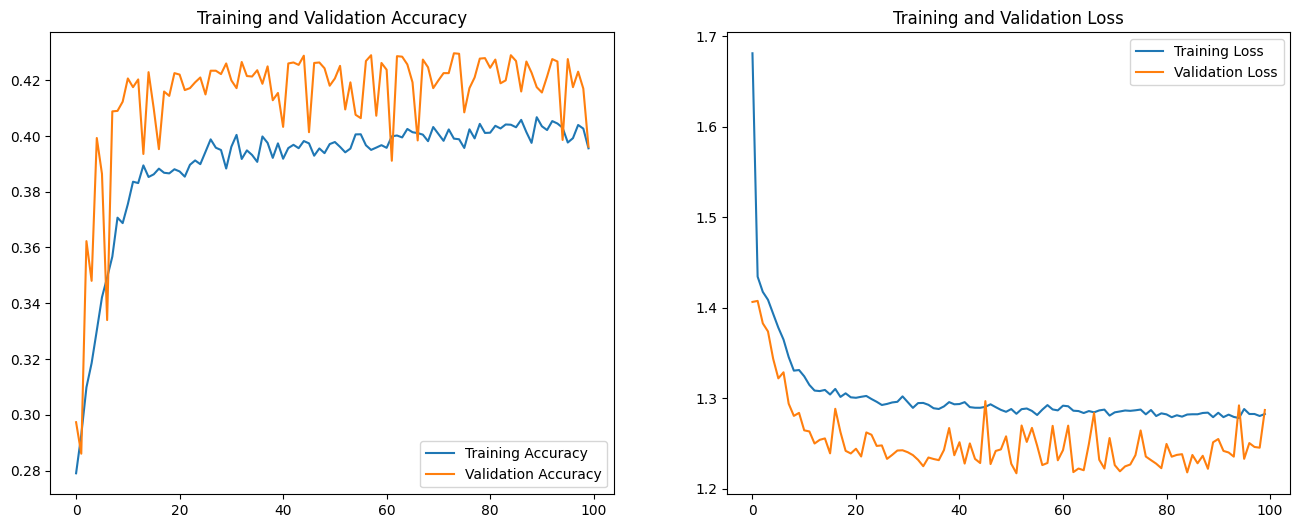

In [10]:
res_hsv_pre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 16s 38ms/step - loss: 0.8731 - accuracy: 0.6175 - val_loss: 0.7434 - val_accuracy: 0.6735
Epoch 2/100
360/360 [==============================] - 14s 40ms/step - loss: 0.7626 - accuracy: 0.6671 - val_loss: 0.7152 - val_accuracy: 0.6872
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.7355 - accuracy: 0.6793 - val_loss: 0.7225 - val_accuracy: 0.6728
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 0.7274 - accuracy: 0.6862 - val_loss: 0.6784 - val_accuracy: 0.6983
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 0.7098 - accuracy: 0.6929 - val_loss: 0.6738 - val_accuracy: 0.6943
Epoch 6/100
360/360 [==============================] - 13s 38ms/step - loss: 0.6957 - accuracy: 0.6

Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5839 - accuracy: 0.7552 - val_loss: 0.6025 - val_accuracy: 0.7473
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5843 - accuracy: 0.7588 - val_loss: 0.5809 - val_accuracy: 0.7654
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5803 - accuracy: 0.7577 - val_loss: 0.5941 - val_accuracy: 0.7537
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5766 - accuracy: 0.7574 - val_loss: 0.5748 - val_accuracy: 0.7614
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5768 - accuracy: 0.7588 - val_loss: 0.5825 - val_accuracy: 0.7602
Epoch 63/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5806 - accuracy: 0.7572 - val_loss: 0.6132 - val_accuracy: 0.7516
Epoch 64/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5735 - accuracy: 0.7613 - val_loss: 0.5989 -

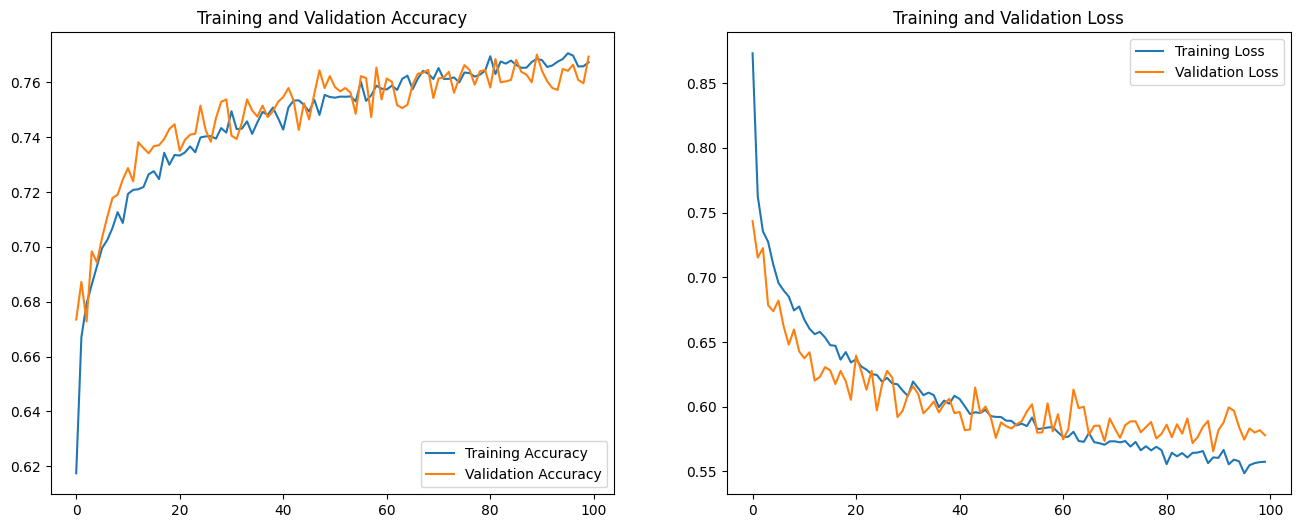

In [11]:
res_hsv_nonpre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 39ms/step - loss: 1.6970 - accuracy: 0.2711 - val_loss: 1.4241 - val_accuracy: 0.2860
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4332 - accuracy: 0.2870 - val_loss: 1.4154 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4271 - accuracy: 0.2902 - val_loss: 1.4198 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4268 - accuracy: 0.2885 - val_loss: 1.4162 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4253 - accuracy: 0.2921 - val_loss: 1.4169 - val_accuracy: 0.2860
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4227 - accuracy: 0.2939 - val_loss: 1.4143 - val_accuracy: 0.2860
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4232 - accuracy: 0.2919 - val_loss: 1.4141 - val_accuracy: 0.2860
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4225 - accuracy: 0.2936 - val_loss: 1.4128 - val_accuracy: 0.2860
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4233 - accuracy: 0.2938 - val_loss: 1.4151 - val_accuracy: 0.2860
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4227 - accuracy: 0.2932 - val_loss: 1.4141 - val_accuracy: 0.2860
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4225 - accuracy: 0.2939 - val_loss: 1.4142 - val_accuracy: 0.2860
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4224 - accuracy: 0.2936 - val_loss: 1.4149 -

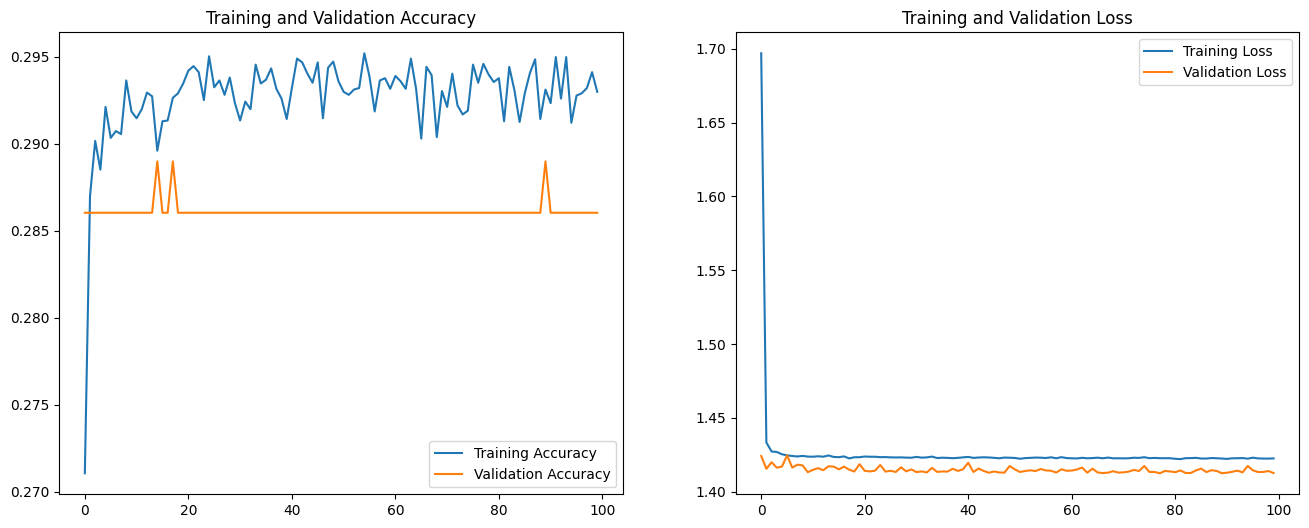

In [12]:
res_yuv_pre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 18s 40ms/step - loss: 1.0980 - accuracy: 0.5013 - val_loss: 0.8560 - val_accuracy: 0.6407
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8903 - accuracy: 0.6073 - val_loss: 0.7951 - val_accuracy: 0.6396
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8528 - accuracy: 0.6293 - val_loss: 0.7777 - val_accuracy: 0.6454
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8290 - accuracy: 0.6421 - val_loss: 0.7754 - val_accuracy: 0.6497
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8039 - accuracy: 0.6530 - val_loss: 0.7340 - val_accuracy: 0.6824
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.7968 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6360 - accuracy: 0.7381 - val_loss: 0.5506 - val_accuracy: 0.7730
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6367 - accuracy: 0.7388 - val_loss: 0.5644 - val_accuracy: 0.7728
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6325 - accuracy: 0.7429 - val_loss: 0.5624 - val_accuracy: 0.7767
Epoch 59/100
360/360 [==============================] - 13s 38ms/step - loss: 0.6342 - accuracy: 0.7373 - val_loss: 0.5769 - val_accuracy: 0.7520
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6352 - accuracy: 0.7390 - val_loss: 0.5843 - val_accuracy: 0.7572
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6332 - accuracy: 0.7416 - val_loss: 0.5747 - val_accuracy: 0.7610
Epoch 62/100
360/360 [==============================] - 13s 38ms/step - loss: 0.6338 - accuracy: 0.7403 - val_loss: 0.5618 -

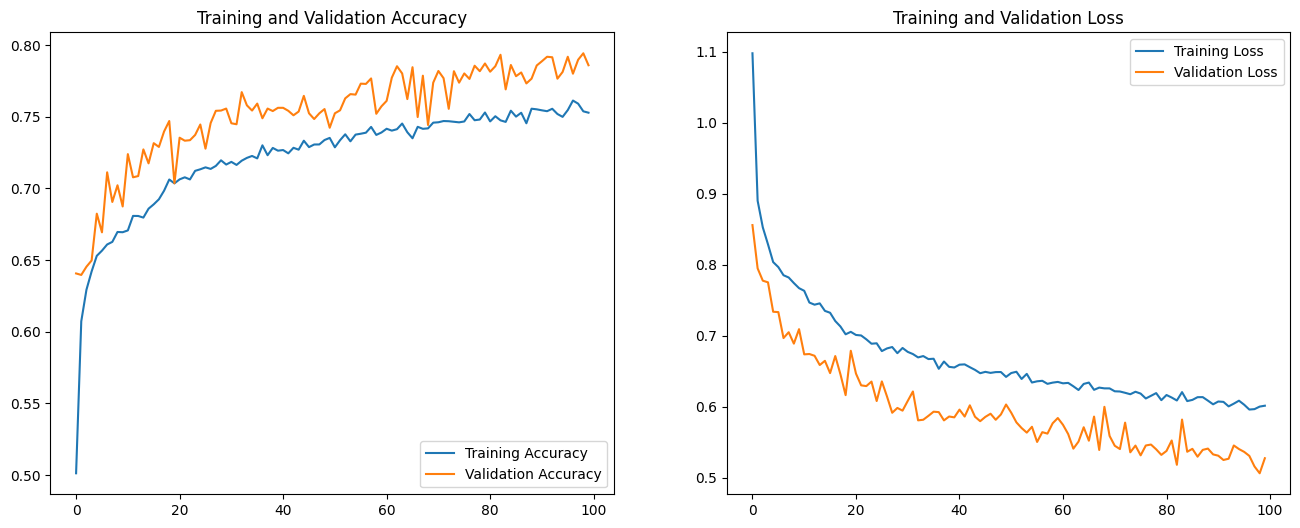

In [13]:
res_yuv_nonpre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 39ms/step - loss: 1.7091 - accuracy: 0.2716 - val_loss: 1.4220 - val_accuracy: 0.2840
Epoch 2/100
360/360 [==============================] - 14s 39ms/step - loss: 1.4428 - accuracy: 0.2781 - val_loss: 1.4249 - val_accuracy: 0.2890
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4318 - accuracy: 0.2865 - val_loss: 1.4195 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4273 - accuracy: 0.2866 - val_loss: 1.4175 - val_accuracy: 0.2746
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4262 - accuracy: 0.2857 - val_loss: 1.4172 - val_accuracy: 0.2890
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4226 - accuracy: 0.2939 - val_loss: 1.4149 - val_accuracy: 0.2860
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4223 - accuracy: 0.2946 - val_loss: 1.4122 - val_accuracy: 0.2890
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4230 - accuracy: 0.2895 - val_loss: 1.4144 - val_accuracy: 0.2860
Epoch 59/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4227 - accuracy: 0.2932 - val_loss: 1.4150 - val_accuracy: 0.2860
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4228 - accuracy: 0.2899 - val_loss: 1.4144 - val_accuracy: 0.2860
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4227 - accuracy: 0.2926 - val_loss: 1.4139 - val_accuracy: 0.2860
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4229 - accuracy: 0.2913 - val_loss: 1.4162 -

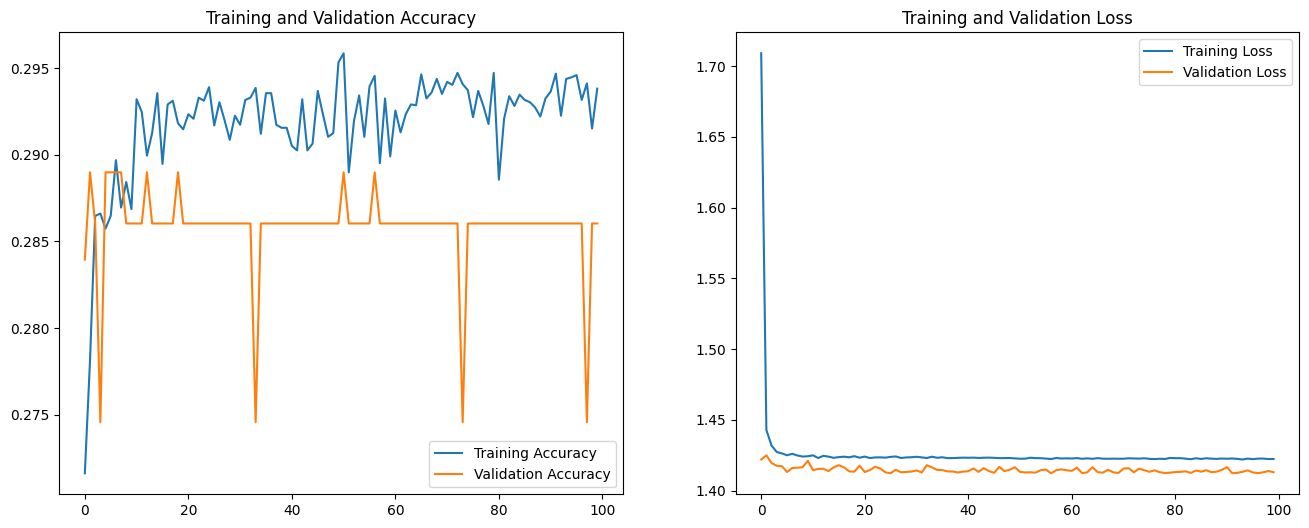

In [14]:
res_ydbdr_pre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 18s 45ms/step - loss: 1.0575 - accuracy: 0.5247 - val_loss: 0.8730 - val_accuracy: 0.6276
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 0.9027 - accuracy: 0.6038 - val_loss: 0.8431 - val_accuracy: 0.6080
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8652 - accuracy: 0.6253 - val_loss: 0.8396 - val_accuracy: 0.6375
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8422 - accuracy: 0.6320 - val_loss: 0.8489 - val_accuracy: 0.6004
Epoch 5/100
360/360 [==============================] - 13s 38ms/step - loss: 0.8386 - accuracy: 0.6354 - val_loss: 0.7752 - val_accuracy: 0.6610
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.8243 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6846 - accuracy: 0.7113 - val_loss: 0.6379 - val_accuracy: 0.7313
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6890 - accuracy: 0.7105 - val_loss: 0.6624 - val_accuracy: 0.7067
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6815 - accuracy: 0.7128 - val_loss: 0.6168 - val_accuracy: 0.7418
Epoch 59/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6815 - accuracy: 0.7154 - val_loss: 0.6349 - val_accuracy: 0.7315
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6785 - accuracy: 0.7148 - val_loss: 0.6582 - val_accuracy: 0.7086
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6827 - accuracy: 0.7132 - val_loss: 0.6425 - val_accuracy: 0.7292
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6751 - accuracy: 0.7154 - val_loss: 0.6246 -

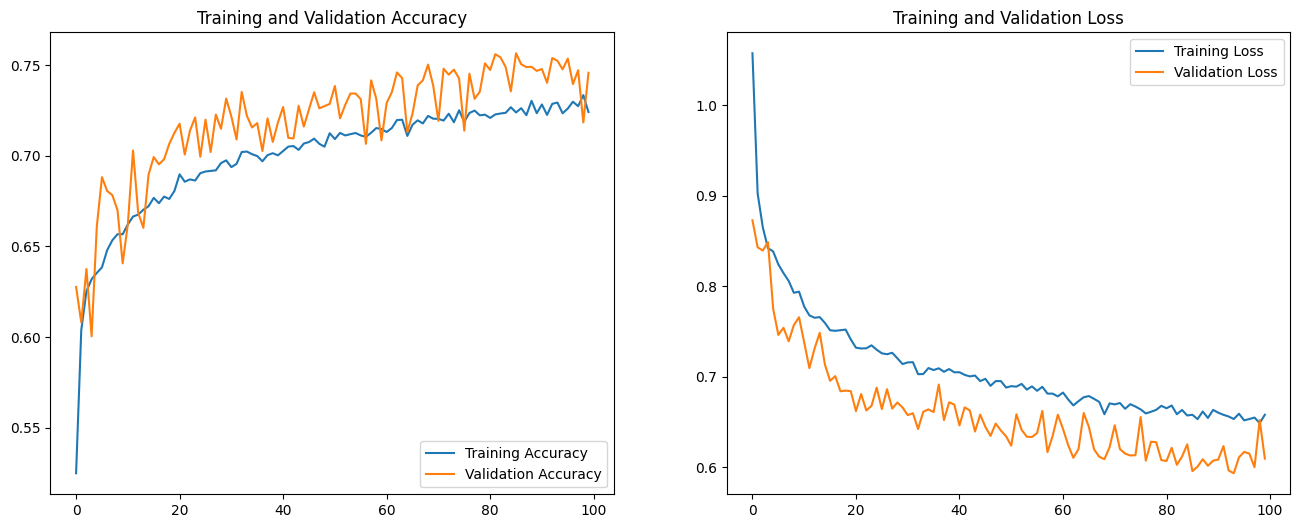

In [15]:
res_ydbdr_nonpre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)

In [16]:
# !mkdir vgg16_nontrainable
pd.DataFrame(res_rgb).to_csv("vgg16_nontrainable/res_rgb.csv", index=False)
pd.DataFrame(res_lab_pre).to_csv("vgg16_nontrainable/res_lab_pre.csv", index=False)
pd.DataFrame(res_lab_nonpre).to_csv("vgg16_nontrainable/res_lab_nonpre.csv", index=False)
pd.DataFrame(res_xyz_pre).to_csv("vgg16_nontrainable/res_xyz_pre.csv", index=False)
pd.DataFrame(res_xyz_nonpre).to_csv("vgg16_nontrainable/res_xyz_nonpre.csv", index=False)
pd.DataFrame(res_hsv_pre).to_csv("vgg16_nontrainable/res_hsv_pre.csv", index=False)
pd.DataFrame(res_hsv_nonpre).to_csv("vgg16_nontrainable/res_hsv_nonpre.csv", index=False)
pd.DataFrame(res_yuv_pre).to_csv("vgg16_nontrainable/res_yuv_pre.csv", index=False)
pd.DataFrame(res_yuv_nonpre).to_csv("vgg16_nontrainable/res_yuv_nonpre.csv", index=False)
pd.DataFrame(res_ydbdr_pre).to_csv("vgg16_nontrainable/res_ydbdr_pre.csv", index=False)
pd.DataFrame(res_ydbdr_nonpre).to_csv("vgg16_nontrainable/res_ydbdr_nonpre.csv", index=False)